Score and explain a `damaging` prediction.

Requires the "editquality" repository is checked out under your home directory.

In [1]:
import os.path

from revscoring import Model


model_path = os.path.expanduser("~/editquality/models/enwiki.damaging.gradient_boosting.model")
sm = Model.load(open(model_path), error_on_env_check=False)

/home/awight/venv/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Differences between the current environment and the environment in which the model was constructed environment were detected:
 - platform 'Linux-4.9.0-6-amd64-x86_64-with-debian-9.4' mismatch with original environment 'Linux-4.16.0-x86_64-with-debian-9.4'
 - release '4.9.0-6-amd64' mismatch with original environment '4.16.0'
 - revscoring_version '2.2.2' mismatch with original environment '2.2.5'
 - version '#1 SMP Debian 4.9.82-1+deb9u3 (2018-03-02)' mismatch with original environment '#1 SMP Wed Apr 18 14:02:11 PDT 2018'


In [2]:
import mwapi
from revscoring.extractors import api

extractor = api.Extractor(mwapi.Session("https://en.wikipedia.org", user_agent="ORES-LIME demo"))

In [3]:
# Load training set
from revscoring.utilities.util import read_observations

observations = list(read_observations(open(os.path.expanduser("~/editquality/datasets/enwiki.labeled_revisions.w_cache.20k_2015.json"))))

Pick a revision, extract the features and score.

In [4]:
import numpy as np

# Add to list
# rev_to_score = 846560713
# Vandalism
rev_to_score = 846560716
features = [str(f) for f in sm.features]
feature_values = np.array(list(extractor.extract(rev_to_score, sm.features)))

prediction = sm.score(feature_values)

print("https://en.wikipedia.org/?diff={}".format(rev_to_score))
print(np.array(list(zip(features, feature_values))))
print(prediction)

https://en.wikipedia.org/?diff=846560716
[['feature.revision.page.is_articleish' '1.0']
 ['feature.revision.page.is_mainspace' '1.0']
 ['feature.revision.page.is_draftspace' '0.0']
 ['feature.log((wikitext.revision.parent.chars + 1))' '10.40289827348682']
 ['feature.log((AggregatorsScalar(<datasource.tokenized(datasource.revision.parent.text)>) + 1))'
  '9.296334565143043']
 ['feature.log((AggregatorsScalar(<datasource.wikitext.revision.parent.words>) + 1))'
  '8.38662882139512']
 ['feature.log((AggregatorsScalar(<datasource.wikitext.revision.parent.uppercase_words>) + 1))'
  '3.044522437723423']
 ['feature.log((wikitext.revision.parent.headings + 1))'
  '2.70805020110221']
 ['feature.log((wikitext.revision.parent.wikilinks + 1))'
  '5.3471075307174685']
 ['feature.log((wikitext.revision.parent.external_links + 1))'
  '2.772588722239781']
 ['feature.log((wikitext.revision.parent.templates + 1))'
  '3.4657359027997265']
 ['feature.log((wikitext.revision.parent.ref_tags + 1))'
  '3.21887

Set up a LIME explainer for this model.  It will randomly perturb features around the 

In [5]:
# TODO: Also explain as text, using our own explainer to run variations.
from lime.lime_tabular import LimeTabularExplainer

def score(samples):
    raw_results = [np.array([sm.score(v)["probability"][t] for t in [False, True]]) for v in samples]
    return np.array(raw_results)

# Transform training data into a numpy matrix.
train = np.array([np.array([o["cache"][k] for k in features]) for o in observations])

# Identify which features are booleans.  Can we introspect the features?  Does LIME need to know about integers vs floats?
#categorical_features = [0, 1, 2, 45, 46, 47, 48, 49, 50, 51, 54]

# FIXME: randomly try adding the integers.
categorical_features = [0, 1, 2, 16, 17, 18, 22, 23, 24, 25, 26, 27, 28, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 73, 74, 75, 76, 77, 78, 79]

explainer = LimeTabularExplainer(
    train,
    mode="classification",
    feature_names=features,
    categorical_features=categorical_features,
    class_names=["not damaging", "damaging"],
    discretize_continuous=True
)

Create an explainer for this prediction.

In [6]:
exp = explainer.explain_instance(
    np.array(feature_values),
    score,
    num_features=10,
    top_labels=2
)

/home/awight/venv/lib/python3.5/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.53789790466599e-28 / 1.1102230246251565e-16
  RuntimeWarning)


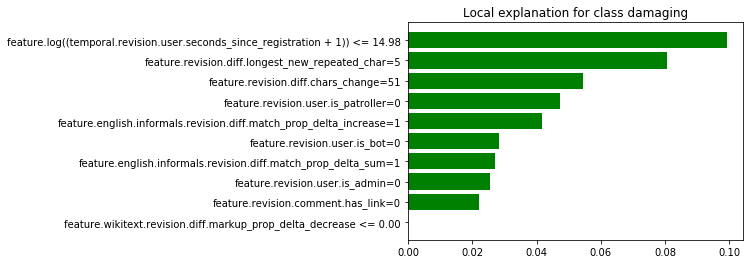

In [7]:
%matplotlib inline
fig = exp.as_pyplot_figure(label=int(prediction["prediction"]))

In [8]:
exp.as_list(label=int(prediction["prediction"]))

[('feature.log((temporal.revision.user.seconds_since_registration + 1)) <= 14.98',
  0.09930807278167873),
 ('feature.revision.diff.longest_new_repeated_char=5', 0.08069852544829675),
 ('feature.revision.diff.chars_change=51', 0.0544306543502047),
 ('feature.revision.user.is_patroller=0', 0.047186606785062014),
 ('feature.english.informals.revision.diff.match_prop_delta_increase=1',
  0.041716028912367496),
 ('feature.revision.user.is_bot=0', 0.028174494671761665),
 ('feature.english.informals.revision.diff.match_prop_delta_sum=1',
  0.0270605359833338),
 ('feature.revision.user.is_admin=0', 0.025508282466766608),
 ('feature.revision.comment.has_link=0', 0.022145485222145392),
 ('feature.wikitext.revision.diff.markup_prop_delta_decrease <= 0.00', 0.0)]